In [2]:
from models.waffleiron.segmenter import Segmenter
import torch
from datasets import LIST_DATASETS, Collate
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import argparse
import wandb
from torchmetrics.classification import MulticlassJaccardIndex
import copy

# Note: this example requires the torchmetrics library: https://torchmetrics.readthedocs.io
import torchmetrics
from tqdm import tqdm

import torchhd
from torchhd.models import Centroid
from torchhd import embeddings

wandb.login(key="9487c04b8eff0c16cac4e785f2b57c3a475767d3")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))
device_string = "cuda:0" if torch.cuda.is_available() else "cpu"

model = Segmenter(
    input_channels=5,
    feat_channels=768,
    depth=48,
    grid_shape=[[256, 256], [256, 32], [256, 32]],
    nb_class=16, # class for prediction
    #drop_path_prob=config["waffleiron"]["drop_path"],
    layer_norm=True,
)

# Load pretrained model
ckpt = torch.load('/root/main/ScaLR/saved_models/ckpt_last_scalr.pth', map_location=device_string) # cuda:0
ckpt = ckpt["net"]

new_ckpt = {}
for k in ckpt.keys():
    if k.startswith("module"):
        if k.startswith("module.classif.0"):
            continue
        elif k.startswith("module.classif.1"):
            new_ckpt["classif" + k[len("module.classif.1") :]] = ckpt[k]
        else:
            new_ckpt[k[len("module.") :]] = ckpt[k]
    else:
        new_ckpt[k] = ckpt[k]

model.load_state_dict(new_ckpt)

if device_string != 'cpu':
    torch.cuda.set_device(device_string) # cuda:0
    model = model.cuda(device_string) # cuda:0

model.eval()

kwargs = {
        "rootdir": '/root/main/dataset/nuscenes',
        "input_feat": ["xyz", "intensity", "radius"],
        "voxel_size": 0.1,
        "num_neighbors": 16,
        "dim_proj": [2, 1, 0],
        "grids_shape": [[256, 256], [256, 32], [256, 32]],
        "fov_xyz": [[-64, -64, -8], [64, 64, 8]], # Check here
    }

# Get datatset
DATASET = LIST_DATASETS.get("nuscenes")

# Train dataset
dataset = DATASET(
    phase="train",
    **kwargs,
)
dataset_train = copy.deepcopy(dataset)
dataset_test = copy.deepcopy(dataset)
dataset_train.init_training()
dataset_test.init_testing()

train_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=1,
        pin_memory=True,
        drop_last=True,
        collate_fn=Collate(),
    )

test_loader = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=1,
        pin_memory=True,
        drop_last=True,
        collate_fn=Collate(),
    )

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Using cuda device


/tmp/ipykernel_21716/190092510.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('/root/main/ScaLR/saved_models/ckpt_last_scalr.pth', map_location=devic

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.639 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


AttributeError: 'NuScenesSemSeg' object has no attribute 'init_testing'

In [17]:
def forward_model(it, batch, stop):
    feat = batch["feat"]
    labels = batch["labels_orig"]
    cell_ind = batch["cell_ind"]
    occupied_cell = batch["occupied_cells"]
    neighbors_emb = batch["neighbors_emb"]
    if device_string != 'cpu':
        feat = feat.cuda(0, non_blocking=True)
        labels = labels.cuda(0, non_blocking=True)
        batch["upsample"] = [
            up.cuda(0, non_blocking=True) for up in batch["upsample"]
        ]
        cell_ind = cell_ind.cuda(0, non_blocking=True)
        occupied_cell = occupied_cell.cuda(0, non_blocking=True)
        neighbors_emb = neighbors_emb.cuda(0, non_blocking=True)

    with torch.no_grad():
        out = model(feat, cell_ind, occupied_cell, neighbors_emb, stop)
        embed, tokens, soa_result = out[0][0], out[1][0], out[2]
        embed = embed.transpose(0, 1)
        tokens = tokens.transpose(0, 1)

        #labels_v = [[] for i in range(embed.shape[0])]
        #for i, vox in enumerate(batch["upsample"][0]):
        #    labels_v[vox].append(labels[i])
        #labels_v_single = []
        #for labels_ in labels_v:
        #    lab_tens = torch.tensor(labels_)
        #    most_common_value = torch.bincount(lab_tens).argmax()
        #    labels_v_single.append(most_common_value)
    
    return tokens, soa_result # labels_v_single,

# Distribution

In [13]:
from tqdm import tqdm

stop = 0
class_count = {}
for c in range(16):
    class_count[c] = 0

for it, batch in tqdm(enumerate(train_loader)):
    
    # Network inputs
    
    tokens, labels_v_single, soa_result = forward_model(it, batch, stop)
    labels_v_single = torch.tensor(labels_v_single)
    for c in range(16):
        class_count[c] += int(torch.bincount(labels_v_single)[c])

print(class_count)

282it [04:55,  1.05s/it]

{0: 25304, 1: 909, 2: 31833, 3: 216325, 4: 19307, 5: 4368, 6: 27545, 7: 2813, 8: 8885, 9: 86313, 10: 1380927, 11: 57460, 12: 311006, 13: 279007, 14: 1280101, 15: 925484}


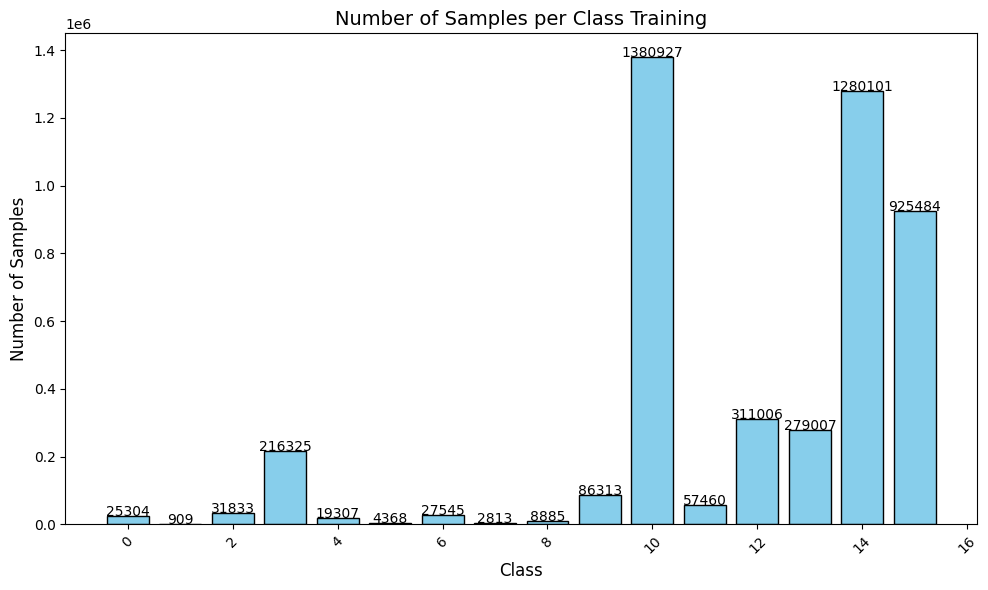

In [14]:
import matplotlib.pyplot as plt

def visualize_samples_per_class(data_dict, title):
    """
    Visualizes the number of samples per class from a dictionary.

    Args:
        data_dict (dict): Dictionary where keys are class labels and values are the number of samples.
    """
    # Extract keys and values from the dictionary
    classes = list(data_dict.keys())
    sample_counts = list(data_dict.values())
    
    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(classes, sample_counts, color='skyblue', edgecolor='black')
    
    # Add labels and title
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.title(f'Number of Samples per Class {title}', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    
    # Add value annotations on each bar
    for i, count in enumerate(sample_counts):
        plt.text(i, count + 0.5, str(count), ha='center', fontsize=10)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


visualize_samples_per_class(class_count, "Training")

In [15]:
from tqdm import tqdm

stop = 48
class_count_testing = {}
for c in range(16):
    class_count_testing[c] = 0

for it, batch in tqdm(enumerate(test_loader)):
    
    # Network inputs
    
    tokens, labels_v_single, soa_result = forward_model(it, batch, stop)
    labels_v_single = torch.tensor(labels_v_single)
    for c in range(16):
        class_count_testing[c] += int(torch.bincount(labels_v_single)[c])

print(class_count_testing)

61it [01:03,  1.04s/it]

{0: 7970, 1: 192, 2: 11205, 3: 48925, 4: 5963, 5: 340, 6: 4583, 7: 607, 8: 1395, 9: 23627, 10: 295898, 11: 8669, 12: 67893, 13: 51567, 14: 276555, 15: 194949}


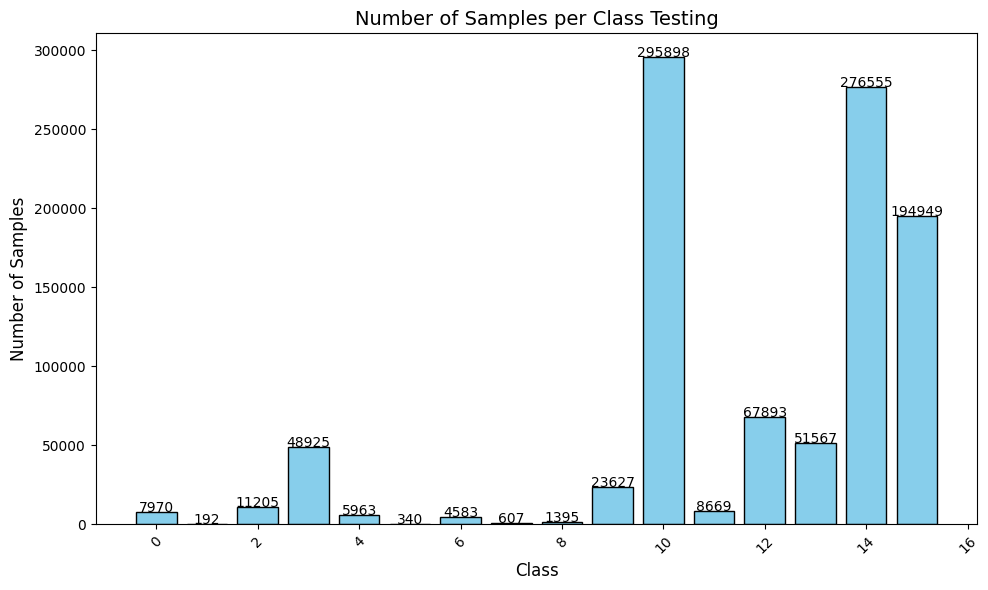

In [16]:
visualize_samples_per_class(class_count_testing, "Testing")

# SoA

In [ ]:
from torchmetrics.classification import MulticlassJaccardIndex

miou = MulticlassJaccardIndex(num_classes=16, average=None).to(device)

stop = 48

output_array = []
labels_array = []

dataset_test = copy.deepcopy(dataset)
dataset_test.init_test()

test_loader = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=1,
        pin_memory=True,
        drop_last=True,
        collate_fn=Collate(),
    )

for it, batch in tqdm(enumerate(test_loader)):
    
    # Network inputs  
    tokens, soa_result = forward_model(it, batch, stop)

    labels = batch['labels_orig']
    where = labels != 255
    labels_array += list(labels[where])
    
    out_upsample = []
    for id_b, closest_point in enumerate(batch["upsample"]):
        temp = soa_result[id_b, :, closest_point]
        out_upsample.append(temp.T)
    pred_label = torch.cat(out_upsample, dim=0)

    pred_label = torch.argmax(pred_label, axis = 1)
    print(pred_label)
    x = input()
    
    output_array += list(pred_label[where])

0it [00:00, ?it/s]

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')


In [47]:
print(output_array[100:200])

[tensor(1, device='cuda:0'), tensor(5, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(5, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='c

In [46]:
labels_array[0:100]

[tensor(12),
 tensor(12),
 tensor(12),
 tensor(12),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(12),
 tensor(12),
 tensor(12),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(12),
 tensor(12),
 tensor(12),
 tensor(14),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(12),
 tensor(12),
 tensor(12),
 tensor(14),
 tensor(14),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(12),
 tensor(12),
 tensor(12),
 tensor(14),
 tensor(14),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(12),
 tensor(12),
 tensor(13),
 tensor(14),
 tensor(14),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(15),
 tensor(12),
 tensor(12),
 tensor(12),
 tensor(12),
 tensor(13),
 tensor(13),
 tensor(14),
 tensor(14),
 tensor(14),
 tensor(14),
 tensor(15),

In [26]:
labels_array = torch.tensor(labels_array).to(device)
output_array = torch.tensor(output_array).to(device)

#l = labels_array[not_noise].to(device)
#out = output_array[not_noise].to(device)

accuracy = miou(output_array, labels_array)
mean = torch.mean(accuracy)

print(f"Mean accuracy of {mean}")
#log_data = {f"class_{i}_IoU": c for i, c in enumerate(accuracy)}
#log_data["meanIoU"] = mean

ValueError: only one element tensors can be converted to Python scalars

In [56]:
accuracy

tensor([1.7275e-02, 3.3197e-04, 2.2100e-04, 0.0000e+00, 1.4082e-03, 4.8184e-04,
        3.3597e-03, 0.0000e+00, 0.0000e+00, 8.2860e-05, 1.2891e-01, 3.8173e-04,
        0.0000e+00, 0.0000e+00, 3.8878e-03, 3.7226e-03], device='cuda:0')